## Predicting Telugu Bigg Boss (బిగ్ బాస్ తెలుగు) Season 5 Winner

## Dataset https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada


In [86]:
import datetime
print("Notebook was last executed on:", datetime.date.today())

Notebook was last executed on: 2021-09-06


### Importing Required Python Libraries

In [87]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

### Check and import dataset

In [88]:
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 86580 Sep  6 08:42 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 689 rows and 24 columns in the dataset


## Exploratory Data Analysis (EDA)

In [89]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,3.0,0.0,0.0,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,1.0,0.0,0.0,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,1.0,0.0,0.0,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,1.0,0.0,0.0,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony TV,2.72,6.0,0.0,0.0,NaN,1.0,0.0


In [90]:
bigg_boss.tail(10).T

,679,680,681,682,683,684,685,686,687,688
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,3,3,3,3,3,3,3,3,3,3
Name,Noby Marcose,Ramzan Muhammed,Rithu Manthra,Sai Vishnu,Sandhya Manoj,Soorya Menon,Firoz Khan & Sajna Firoz,Michelle Ann Daniel,Angel Thomas,Remya Panickar
Profession,Actor,Dancer,Singer,Commoner,Dancer,Model,Actor & Actress,Actress,Model,Actress
Gender,Male,Male,Female,Male,Female,Female,Couple,Female,Female,Female
Entry Date,14-Feb-21,14-Feb-21,14-Feb-21,14-Feb-21,14-Feb-21,14-Feb-21,NaN,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,NaN,NaN,NaN,NaN,10,13,9,3,4,13
Wild Card,No,No,No,No,No,No,Yes,Yes,Yes,Yes
Season Length,95,95,95,95,95,95,95,95,95,95


In [91]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
213,Hindi,12,Rohit Suchanti,Soap Actor,Male,NaN,NaN,13.0,Yes,105,20,16-Sep-18,30-Dec-18,Salman Khan,NaN,0,Colors,4.99,5.0,0.0,0.0,NaN,0.0,0.0
564,Marathi,1,Aarti Solanki,Comedian,Female,15-Apr-18,NaN,1.0,No,98,18,15-Apr-18,22-Jul-18,Mahesh Manjrekar,NaN,0,Colors Marathi,NaN,1.0,0.0,0.0,NaN,0.0,0.0
541,Tamil,3,Sherin Shringar,Actress,Female,23-Jun-19,NaN,15.0,No,105,17,23-Jun-19,06-Oct-19,Kamal Haasan,NaN,0,Star Vijay,8.80,6.0,0.0,1.0,5.0,1.0,0.0
283,Kannada,2,Santhosh Aryan,Actor,Male,29-Jun-14,NaN,10.0,No,98,15,29-Jun-14,5-Oct-14,Sudeep,NaN,0,Suvarna,NaN,6.0,0.0,0.0,NaN,0.0,0.0
519,Tamil,2,Nithya Balaji,Commoner - Housewife,Female,17-Jun-18,NaN,4.0,No,105,17,17-Jun-18,30-Sep-18,Kamal Haasan,NaN,0,Star Vijay,8.20,4.0,0.0,2.0,NaN,0.0,0.0
643,Malayalam,1,Shweta Menon,Actress,Female,24-Jun-18,NaN,5.0,No,98,18,24-Jun-18,30-Sep-18,Mohanlal,NaN,0,Asianet,10.33,1.0,0.0,1.0,NaN,0.0,0.0
285,Kannada,2,Srujan Lokesh,Actor,Male,29-Jun-14,NaN,14.0,No,98,15,29-Jun-14,5-Oct-14,Sudeep,NaN,0,Suvarna,NaN,5.0,0.0,2.0,NaN,1.0,0.0
85,Hindi,6,Navjot Singh Sidhu,Sports Person,Male,07-Oct-12,NaN,NaN,No,97,19,07-Oct-12,12-Jan-13,Salman Khan,NaN,0,Colors,3.81,1.0,0.0,0.0,NaN,0.0,0.0
390,Kannada,8,Manju Pavagada,Comedian,Male,28-Feb-21,NaN,NaN,No,117,20,28-Feb-21,08-Aug-21,Sudeep,NaN,"50,00,000",Colors Kannada,NaN,9.0,0.0,1.0,9.0,1.0,1.0
432,Telugu,2,Sanjana Anne,Commoner - Pageant Winner,Female,10-Jun-18,NaN,1.0,No,112,18,10-Jun-18,30-Sep-18,Nani,NaN,0,Star Maa,15.00,1.0,0.0,0.0,NaN,0.0,0.0


In [92]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 24 columns):
Language                              689 non-null object
Season Number                         689 non-null int64
Name                                  689 non-null object
Profession                            689 non-null object
Gender                                689 non-null object
Entry Date                            583 non-null object
Elimination Date                      134 non-null object
Elimination Week Number               557 non-null float64
Wild Card                             689 non-null object
Season Length                         689 non-null int64
Number of Housemates                  689 non-null int64
Season Start Date                     689 non-null object
Season End Date                       689 non-null object
Host Name                             689 non-null object
Guest Host Name                       73 non-null object
Prize Money (INR)           

In [93]:
bigg_boss.describe()

,Season Number,Elimination Week Number,Season Length,Number of Housemates,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
count,689.000000,557.000000,689.000000,689.000000,482.000000,652.000000,652.000000,637.000000,92.000000,670.000000,670.000000
mean,4.950653,9.260323,102.766328,18.364296,8.044959,4.164110,0.099693,0.549451,6.673913,0.247761,0.053731
std,3.721466,4.845315,13.763227,2.064217,5.019739,2.976467,0.324428,0.762415,1.617954,0.432035,0.225655
min,1.000000,1.000000,70.000000,15.000000,2.720000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,2.000000,5.000000,98.000000,17.000000,3.810000,2.000000,0.000000,0.000000,6.000000,0.000000,0.000000
50%,4.000000,9.000000,105.000000,18.000000,7.070000,4.000000,0.000000,0.000000,7.000000,0.000000,0.000000
75%,7.000000,14.000000,106.000000,20.000000,11.030000,6.000000,0.000000,1.000000,8.000000,0.000000,0.000000
max,14.000000,20.000000,143.000000,23.000000,20.100000,17.000000,3.000000,5.000000,10.000000,1.000000,1.000000


In [94]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [95]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 24 columns):
Language                              689 non-null object
Season Number                         689 non-null int64
Name                                  689 non-null object
Profession                            689 non-null object
Gender                                689 non-null object
Entry Date                            583 non-null datetime64[ns]
Elimination Date                      134 non-null datetime64[ns]
Elimination Week Number               557 non-null Int32
Wild Card                             689 non-null object
Season Length                         689 non-null int64
Number of Housemates                  689 non-null int64
Season Start Date                     689 non-null datetime64[ns]
Season End Date                       689 non-null datetime64[ns]
Host Name                             689 non-null object
Guest Host Name                       73 non-null objec

In [96]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col,"-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 14
Number of unique values in Name - 682
Number of unique values in Profession - 76
Number of unique values in Gender - 4
Number of unique values in Entry Date - 47
Number of unique values in Elimination Date - 75
Number of unique values in Elimination Week Number - 20
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 17
Number of unique values in Number of Housemates - 8
Number of unique values in Season Start Date - 38
Number of unique values in Season End Date - 36
Number of unique values in Host Name - 12
Number of unique values in Guest Host Name - 4
Number of unique values in Prize Money (INR) - 10
Number of unique values in Broadcasted By - 11
Number of unique values in Average TRP - 25
Number of unique values in Number of Evictions Faced - 17
Number of unique values in Number of re-entries - 4
Number of unique values in Number of times elected as Captain - 6
Numb

In [97]:
# Number of seasons in all Indian languages
print(bigg_boss.groupby('Language')['Season Number'].nunique().sum())

# 38 seasons happened (including current seasons)

38


## Bigg Boss Hindi has many seasons compared to other Indian languages. So, number of housemates are more in Hindi.

In [98]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        14
Kannada       8
Telugu        5
Tamil         4
Malayalam     3
Bengali       2
Marathi       2
Name: Season Number, dtype: int64


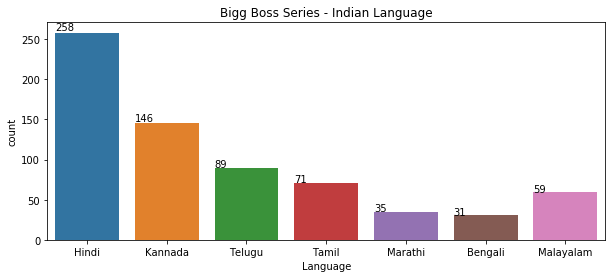

In [99]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     572
Yes    117
Name: Wild Card, dtype: int64 

No     83.0
Yes    17.0
Name: Wild Card, dtype: float64


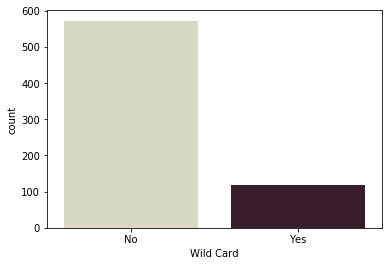

In [100]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100))
sns.countplot(x='Wild Card', data=bigg_boss, palette="ch:.45")

In [101]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession']='Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions 

Actress                  160
Actor                    110
Model                     52
Soap Actress              48
Singer                    41
Commoner                  40
Soap Actor                30
TV Anchor                 22
Comedian                  17
Social Media Star         17
Reality Show Alumni       17
Radio Jockey              15
News Presenter            13
Choreographer             10
Sports Person              9
Film Director              8
Video Jockey               6
Activist                   6
International Star         6
Producer                   5
Politician                 5
Swamiji                    4
Pageant Winner             4
LGBT                       4
Controversial Fame         4
Dancer                     4
Wrestler                   3
Businessman                2
Musician                   2
Fashion Designer           2
Stage Actress              2
Journalist                 2
Film director              1
Dubbing Artist             1
Celebrity Hair

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

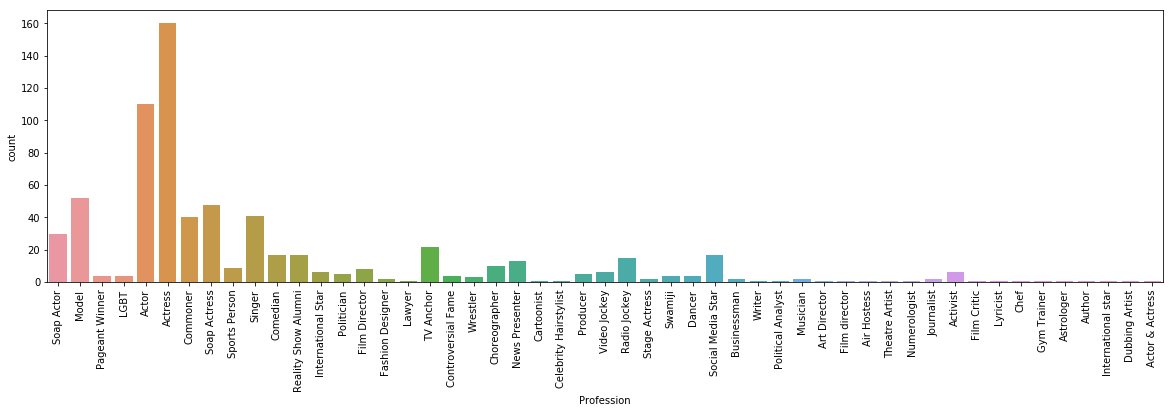

In [102]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20,5))
sns.countplot(x='Profession', data=bigg_boss)
plt.xticks(rotation=90)

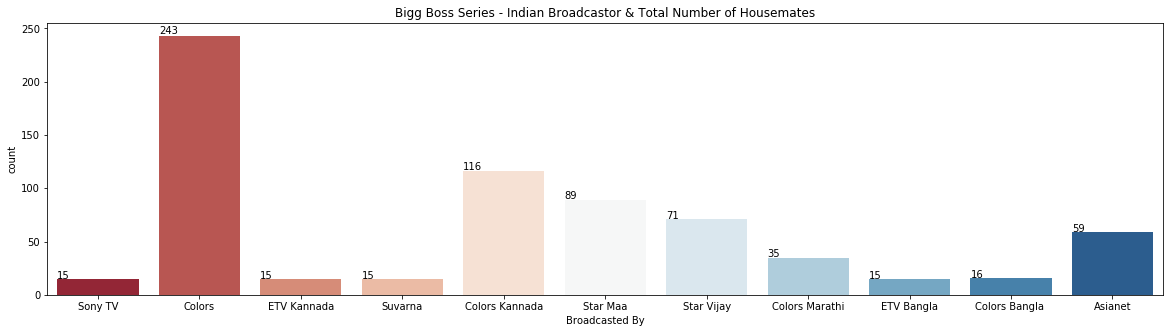

In [103]:
# Broadcastor
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu')
ax.set_title('Bigg Boss Series - Indian Broadcastor & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

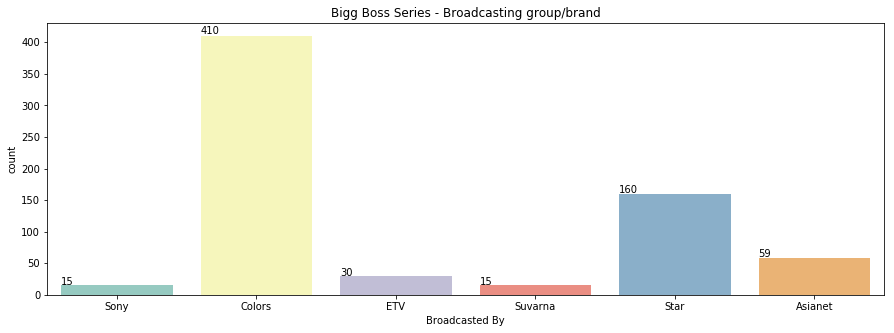

In [104]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0), data=bigg_boss, palette='Set3')
ax.set_title('Bigg Boss Series - Broadcasting group/brand')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [105]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            11
Sudeep                  8
Kamal Haasan            4
Mohanlal                3
Nagarjuna               3
Mahesh Manjrekar        2
Mithun Chakraborthy     2
Amitabh Bachchan        1
Arshad Warsi            1
Jr. NTR                 1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [106]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Farah Khan           1
Ramya Krishnan       1
Samantha Akkineni    1
Sanjay Dutt          1
Name: Season Number, dtype: int64

## In all Bigg Boss competetions, in languages and in all seasons, Female contestants are more

In [107]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(int), "\n")

Female         361
Male           323
Transgender      4
Couple           1
Name: Gender, dtype: int64 

Female         52
Male           47
Transgender     1
Couple          0
Name: Gender, dtype: int64 



### Only 4 Transgenders (LGBT) participated in all Indian languages

In [108]:
# Maximum TRP of Bigg Boss Hindi/India seasons
print("Maximum TRP",bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language  Season Number
  Telugu              4


In [109]:
# Longest season of Bigg Boss Hindi/India seasons
print("Longest season",bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 143 days 

Language  Season Number
   Hindi             14


In [110]:
# Many contestants entered via wild card, but managed to go to Finale
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,2.83,4,0,0,NaN,1,0.0
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,2,0,2,NaN,1,0.0
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,4.95,4,0,1,NaN,1,0.0
75,Hindi,5,Amar Upadhyay,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,7,0,1,NaN,1,0.0
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,5,0,0,NaN,1,0.0
77,Hindi,5,Akashdeep Saigal,Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.19,5,0,1,NaN,1,0.0
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,3.81,6,1,1,NaN,1,0.0
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,4.40,7,0,0,NaN,1,0.0
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,6,0,1,NaN,1,0.0
135,Hindi,8,Dimpy Ganguly,TV Anchor,Female,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,3.77,5,0,1,NaN,1,0.0


## About Winners only

In [111]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony TV,2.72,4,0,0,NaN,1,1.0
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,2.89,4,0,0,NaN,1,1.0
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,NaN,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,2.83,7,0,0,NaN,1,1.0
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,NaN,No,96,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,4.95,4,0,2,NaN,1,1.0
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,NaN,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,4.19,4,0,1,NaN,1,1.0
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,NaN,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,3.81,6,0,1,NaN,1,1.0
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,NaN,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,4.40,7,0,2,NaN,1,1.0
121,Hindi,8,Gautam Gulati,Actor,Male,2014-09-21,NaT,NaN,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,5000000.0,Colors,3.77,10,0,1,NaN,1,1.0
144,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,NaN,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,2.90,6,0,4,NaN,1,1.0
165,Hindi,10,Manveer Gurjar,Commoner,Male,2016-10-16,NaT,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,5000000.0,Colors,3.54,7,0,4,8,1,1.0


In [112]:
# Sum of prize money won by all BB Season winners/participants, in India

from babel.numbers import format_currency
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN'))

# 20 crores and 21 lakh rupees

₹ 20,21,00,000.00


In [113]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

Actor                  10
Actress                 5
Soap Actress            5
Singer                  4
Reality Show Alumni     3
Commoner                2
Soap Actor              2
TV Anchor               2
Model                   1
Comedian                1
Film Director           1
Name: Profession, dtype: int64

In [114]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(),'\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(normalize=True)*100))

Male      26
Female    10
Name: Gender, dtype: int64 

Male      72.0
Female    28.0
Name: Gender, dtype: float64


## No wild card entry housemate won the Bigg Boss competition.

In [115]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Wild Card'].value_counts()

No    36
Name: Wild Card, dtype: int64

In [116]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1,'Number of re-entries'].value_counts()

0    35
Name: Number of re-entries, dtype: int64

In [117]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1,'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

4     7
5     4
6     5
7     6
8     1
9     5
10    1
11    2
12    3
17    1
Name: Number of Evictions Faced, dtype: int64

In [118]:
# Bigg Boss title winner number of times elected as Captain
bigg_boss.loc[bigg_boss.Winner==1,'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain   - Number of winners

0     9
1    10
2    12
3     1
4     2
Name: Number of times elected as Captain, dtype: int64

## BB Telugu Seasons

In [119]:
lang='Telugu'

# All Bigg Boss Telugu Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
404,Telugu,1,Aadarsh Balakrishna,Actor,Male,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,4,0,1,7,1,0.0
405,Telugu,1,Archana,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,6,0,0,5,1,0.0
406,Telugu,1,Dhanraj,Comedian,Male,2017-07-16,2017-08-26,6,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,3,0,0,NaN,0,0.0
407,Telugu,1,Hari Teja,Actress,Female,2017-07-16,2017-09-24,10,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,6,0,1,5,1,0.0
408,Telugu,1,Jyothi,Actress,Female,2017-07-16,2017-07-23,1,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,15.0,1,0,0,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Telugu,5,Sreerama Chandra,Singer,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,Telugu,5,Sunny,Video Jockey,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,Telugu,5,Sweta Varma,Actress,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,Telugu,5,Uma Devi,Actress,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# Bigg Boss Telugu Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
417,Telugu,1,Siva Balaji,Actor,Male,2017-07-16,NaT,NaN,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000.0,Star Maa,15.0,4,0,2,8,1,1.0
427,Telugu,2,Kaushal Manda,Actor,Male,2018-06-10,NaT,NaN,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000.0,Star Maa,15.0,11,0,1,10,1,1.0
446,Telugu,3,Rahul Sipligunj,Singer,Male,2019-07-21,NaT,NaN,No,105,17,2019-07-21,2019-11-03,Nagarjuna,Ramya Krishnan,5000000.0,Star Maa,18.1,12,0,0,9,1,1.0
455,Telugu,4,Abijeet,Actor,Male,2020-09-06,NaT,NaN,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,2500000.0,Star Maa,20.1,12,0,0,9,1,1.0


In [121]:
# Bigg Boss Telugu current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']==4), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner
455,Telugu,4,Abijeet,Actor,Male,2020-09-06,NaT,NaN,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,2500000.0,Star Maa,20.1,12,0,0,9,1,1.0
456,Telugu,4,Akhil Sarthak,Actor,Male,2020-09-06,2020-12-20,15,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,7,0,1,9,1,0.0
457,Telugu,4,Alekya Harika,Social Media Star,Female,2020-09-06,2020-12-20,15,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,10,0,1,7,1,0.0
458,Telugu,4,Amma Rajasekhar,Choreographer,Male,2020-09-06,2020-11-08,9,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,4,0,1,4,0,0.0
459,Telugu,4,Ariyana Glory,TV Anchor,Female,2020-09-06,2020-12-20,15,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,10,0,1,7,1,0.0
460,Telugu,4,Devi Nagavalli,News Presenter,Female,2020-09-06,2020-09-27,3,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,1,0,0,4,0,0.0
461,Telugu,4,Divi Vadthaya,Model,Female,2020-09-06,2020-10-25,7,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,3,0,0,5,0,0.0
462,Telugu,4,Gangavva,Social Media Star,Female,2020-09-06,2020-10-10,5,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,2,0,1,7,0,0.0
463,Telugu,4,Karate Kalyani,Actress,Female,2020-09-06,2020-09-20,2,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,1,0,0,2,0,0.0
464,Telugu,4,Lasya,TV Anchor,Female,2020-09-06,2020-11-22,11,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.1,6,0,1,5,0,0.0


## Preparing Data for ML modelling

In [122]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            106
Elimination Date                      555
Elimination Week Number               132
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                         0
Host Name                               0
Guest Host Name                       616
Prize Money (INR)                      19
Broadcasted By                          0
Average TRP                           207
Number of Evictions Faced              37
Number of re-entries                   37
Number of times elected as Captain     52
Social Media Popularity               597
Finalist                               19
Winner                            

In [123]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [124]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [125]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 28 columns):
Language                              689 non-null object
Season Number                         689 non-null int64
Name                                  689 non-null object
Profession                            689 non-null object
Gender                                689 non-null object
Entry Date                            583 non-null datetime64[ns]
Elimination Date                      134 non-null datetime64[ns]
Elimination Week Number               557 non-null Int32
Wild Card                             689 non-null object
Season Length                         689 non-null int64
Number of Housemates                  689 non-null int64
Season Start Date                     689 non-null datetime64[ns]
Season End Date                       689 non-null datetime64[ns]
Host Name                             689 non-null object
Guest Host Name                       73 non-null objec

In [126]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,3,0,0,NaN,0,0.0,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,2006,2007,4,1
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony TV,2.72,6,0,0,NaN,1,0.0,2006,2007,4,1


In [127]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
684,Malayalam,3,Soorya Menon,Model,Female,2021-02-14,NaT,13,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,8,0,1,NaN,0,0.0,2021,2021,1,2
685,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Couple,NaT,NaT,9,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,7,0,0,NaN,0,0.0,2021,2021,1,2
686,Malayalam,3,Michelle Ann Daniel,Actress,Female,NaT,NaT,3,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,1,0,0,NaN,0,0.0,2021,2021,1,2
687,Malayalam,3,Angel Thomas,Model,Female,NaT,NaT,4,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,1,0,0,NaN,0,0.0,2021,2021,1,2
688,Malayalam,3,Remya Panickar,Actress,Female,NaT,NaT,13,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.4,3,1,1,NaN,0,0.0,2021,2021,1,2


In [128]:
# Updating last week-end elimination/entries manually
#bigg_boss.iloc[475,23] = 0

In [129]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
438,Telugu,3,Ali Reza,Actor,Male,2019-07-21,2019-11-03,15,No,105,17,2019-07-21,2019-11-03,Nagarjuna,Ramya Krishnan,0.0,Star Maa,18.100000,3,1,1,6,1,0.0,2019,2019,3,4
67,Hindi,5,Pooja Bedi,News Presenter,Female,2011-10-02,NaT,8,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.190000,2,0,0,NaN,0,0.0,2011,2012,4,1
461,Telugu,4,Divi Vadthaya,Model,Female,2020-09-06,2020-10-25,7,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha Akkineni,0.0,Star Maa,20.100000,3,0,0,5,0,0.0,2020,2020,3,4
643,Malayalam,1,Shweta Menon,Actress,Female,2018-06-24,NaT,5,No,98,18,2018-06-24,2018-09-30,Mohanlal,NaN,0.0,Asianet,10.330000,1,0,1,NaN,0,0.0,2018,2018,2,3
70,Hindi,5,Shakti Kapoor,Actor,Male,2011-10-02,NaT,4,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,4.190000,1,0,2,NaN,0,0.0,2011,2012,4,1
379,Kannada,7,Shine Shetty,Actor,Male,2019-10-13,NaT,NaN,No,113,20,2019-10-13,2020-02-02,Sudeep,NaN,5000000.0,Colors Kannada,8.044959,8,0,2,9,1,1.0,2019,2020,4,1
620,Bengali,2,Mikhail Bora,Commoner,Male,2016-04-04,NaT,NaN,No,97,16,2016-04-04,2016-07-15,Mithun Chakraborthy,NaN,0.0,Colors Bangla,6.500000,3,0,1,NaN,0,0.0,2016,2016,2,3
17,Hindi,2,Debojit Saha,Singer,Male,2008-08-17,NaT,10,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,2.890000,2,0,0,NaN,0,0.0,2008,2008,3,4
494,Tamil,1,Anuya Bhagvath,Actress,Female,2017-06-25,NaT,1,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,NaN,0.0,Star Vijay,7.800000,1,0,0,NaN,0,0.0,2017,2017,2,3
688,Malayalam,3,Remya Panickar,Actress,Female,NaT,NaT,13,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,12.400000,3,1,1,NaN,0,0.0,2021,2021,1,2


In [130]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Telugu season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
474,Telugu,5,Anee,Choreographer,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
475,Telugu,5,Hamida,Actress,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
476,Telugu,5,Jaswanth Padala,Model,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
477,Telugu,5,Kajal,Radio Jockey,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
478,Telugu,5,Lahari Shari,Actress,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
479,Telugu,5,Lobo,Video Jockey,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
480,Telugu,5,Maanas,Soap Actor,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
481,Telugu,5,Nataraj,Choreographer,Male,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
482,Telugu,5,Priya,Actress,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4
483,Telugu,5,Priyanka Singh,Comedian,Female,2021-09-05,NaT,NaN,No,106,19,2021-09-05,2021-12-19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,NaN,2021,2021,3,4


In [131]:
BB_telugu_participant = test[['Name']]
BB_telugu_participant.reset_index(drop=True, inplace=True)
BB_telugu_participant

,Name
0,Anee
1,Hamida
2,Jaswanth Padala
3,Kajal
4,Lahari Shari
5,Lobo
6,Maanas
7,Nataraj
8,Priya
9,Priyanka Singh


In [132]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date",], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [133]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Winner,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,3,0,0,NaN,0,0.0,2006,2007,4,1
1,Hindi,1,Model,Female,5,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,2006,2007,4,1
3,Hindi,1,LGBT,Transgender,1,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,1,0,0,NaN,0,0.0,2006,2007,4,1
4,Hindi,1,Model,Female,12,No,86,15,Arshad Warsi,NaN,0.0,Sony TV,2.72,6,0,0,NaN,1,0.0,2006,2007,4,1


In [134]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Social Media Popularity,Finalist,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
474,Telugu,5,Choreographer,Female,NaN,No,106,19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,2021,2021,3,4
475,Telugu,5,Actress,Female,NaN,No,106,19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,2021,2021,3,4
476,Telugu,5,Model,Male,NaN,No,106,19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,2021,2021,3,4
477,Telugu,5,Radio Jockey,Female,NaN,No,106,19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,2021,2021,3,4
478,Telugu,5,Actress,Female,NaN,No,106,19,Nagarjuna,NaN,NaN,Star Maa,8.044959,1,0,0,NaN,NaN,2021,2021,3,4


In [135]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.626866
1.0     5.373134
Name: Winner, dtype: float64


In [136]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [137]:
print(train2.shape)
print(test.shape)

(670, 238)
(19, 238)


In [138]:
train2.isnull().sum().sort_values(ascending=False)

Season Ending Quarter_4       0
Elimination Week Number_4     0
Elimination Week Number_16    0
Elimination Week Number_15    0
Elimination Week Number_14    0
                             ..
Average TRP_4.19              0
Average TRP_3.81              0
Average TRP_3.77              0
Average TRP_3.54              0
Language_Hindi                0
Length: 238, dtype: int64

In [139]:
# train2.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)
# test.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)

In [140]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Profession_Actor,Profession_Actor & Actress,Profession_Actress,Profession_Air Hostess,Profession_Art Director,Profession_Astrologer,...,Season Starting Year_2016,Season Starting Year_2017,Season Starting Year_2018,Season Starting Year_2019,Season Starting Year_2020,Season Starting Year_2021,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [141]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [142]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2020)
print(x_train.shape, x_val.shape)

(469, 238) (201, 238)


In [143]:
x_train.isnull().sum().sort_values(ascending=False)

Season Ending Quarter_4       0
Elimination Week Number_4     0
Elimination Week Number_16    0
Elimination Week Number_15    0
Elimination Week Number_14    0
                             ..
Average TRP_4.19              0
Average TRP_3.81              0
Average TRP_3.77              0
Average TRP_3.54              0
Language_Hindi                0
Length: 238, dtype: int64

## Machine Learning Modelling

In [144]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)

In [145]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2021, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 91.1366245694604
F1 score for C=1: 96.54073383084577
F1 score for C=10: 98.96236520745555
F1 score for C=100: 98.96236520745555
F1 score for C=1000: 98.96236520745555


In [146]:
logi = LogisticRegression(random_state=2021, C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2021, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [147]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 98.96236520745555
Accuracy Score - 99.00497512437812


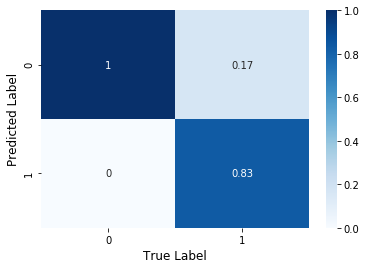

In [148]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.83

In [149]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
6,Maanas,0.000052
12,Shanmukh Jaswanth,0.000032
16,Sweta Varma,0.000030
7,Nataraj,0.000029
5,Lobo,0.000029
15,Sunny,0.000029
18,Vishwa,0.000027
10,Ravi,0.000025
11,Sarayu,0.000016
13,Siri Hanumanth,0.000016


## Predicted Winner for Bigg Boss Telugu Season 5, as per Logistic Regression

In [150]:
# Predicted Winner for Bigg Boss Telugu Season 5, as per LogisticRegression
winner_lg.iloc[np.argwhere(winner_lg.Predicted_Winner == np.amax(winner_lg.Predicted_Winner)).flatten().tolist()]

,Name,Predicted_Winner
6,Maanas,0.000052


In [151]:
# RandomForest
rf = RandomForestClassifier(n_estimators=2000, random_state=2021).fit(x_train, y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=2021,
                       verbose=0, warm_start=False)

In [152]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=500 accuracy 98.5
# n_estimators=1000 accuracy 99.00

F1 Score - 98.96236520745555
Accuracy Score - 99.00497512437812


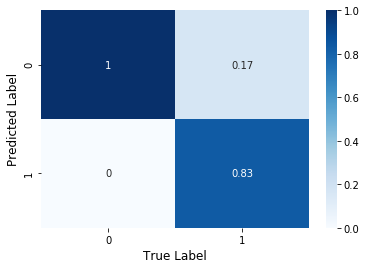

In [153]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.83

In [154]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
18,Vishwa,0.0135
14,Sreerama Chandra,0.0130
12,Shanmukh Jaswanth,0.0055
15,Sunny,0.0055
5,Lobo,0.0055
7,Nataraj,0.0055
10,Ravi,0.0055
2,Jaswanth Padala,0.0050
6,Maanas,0.0050
16,Sweta Varma,0.0045


## Predicted Winner for Bigg Boss Telugu Season 5, as per Random Forest

In [155]:
# Predicted Winner for Bigg Boss Telugu Season 5, as per RandomForest
winner_rf.iloc[np.argwhere(winner_rf.Predicted_Winner == np.amax(winner_rf.Predicted_Winner)).flatten().tolist()]

,Name,Predicted_Winner
18,Vishwa,0.0135


## Machine Learning Models to predict Indian Bigg Boss season Winners

## Kannada Bigg Boss Season8
## https://www.kaggle.com/thirumani/predicting-bigg-boss-kannada-season-8-winner

## Hindi Bigg Boss Season14
## https://www.kaggle.com/thirumani/predicting-bigg-boss-hindi-season-14-winner

## Malayalam Bigg Boss Season3
## https://www.kaggle.com/thirumani/predicting-bigg-boss-malayalam-season-3-winner

## Tamil Bigg Boss Season4
## https://www.kaggle.com/thirumani/predicting-bigg-boss-tamil-season-4-winner